In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams["font.family"] = "serif"
mpl.rcParams.update({'font.size': 14})

from matplotlib.legend_handler import HandlerTuple

In [8]:
p = pathlib.Path('figures')
p.mkdir(parents=True, exist_ok=True)

In [2]:
def calib_curve(probs, labels, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    lefts = bins[:-1]
    rights = bins[1:]
    bin_sizes = np.zeros(n_bins)
    p_true = np.zeros(n_bins)
    p_pred = np.zeros(n_bins)
    for bin_num in range(n_bins):
        ids = (probs >= lefts[bin_num]) & (probs < rights[bin_num])
        bin_sizes[bin_num] = np.sum(ids)
        if bin_sizes[bin_num] == 0:
            p_true[bin_num] = 0
            p_pred[bin_num] = (lefts[bin_num] + rights[bin_num]) / 2
        else:
            p_true[bin_num] = np.sum(labels[ids]) / bin_sizes[bin_num]
            p_pred[bin_num] = np.mean(probs[ids])
    
    pos = (lefts + rights) / 2
    
    ece = np.sum(bin_sizes * np.abs(p_true - p_pred)) / np.sum(bin_sizes)
    acc = np.sum(np.equal(probs > 0.5, labels)) / len(labels)
    mce = np.max(np.abs(p_true - p_pred))
    
    return p_true, p_pred, ece, acc, mce, pos

def calib_curve_f1(probs, labels, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    lefts = bins[:-1]
    rights = bins[1:]
    bin_sizes = np.zeros(n_bins)
    p_true = np.zeros(n_bins)
    p_pred = np.zeros(n_bins)
    for bin_num in range(n_bins):
        ids = (probs >= lefts[bin_num]) & (probs < rights[bin_num])
        bin_sizes[bin_num] = np.sum(ids)
        if bin_sizes[bin_num] == 0:
            p_true[bin_num] = 0
            p_pred[bin_num] = (lefts[bin_num] + rights[bin_num]) / 2
        else:
            p_true[bin_num] = np.sum(labels[ids]) / bin_sizes[bin_num]
            p_pred[bin_num] = np.mean(probs[ids])
    
    tp = np.sum(np.logical_and(probs > 0.5, labels == 1))
    fp = np.sum(np.logical_and(probs > 0.5, labels == 0))
    fn = np.sum(np.logical_and(probs < 0.5, labels == 1))
    
    f1 = 2 * tp / (2 * tp + fp + fn)
    
    pos = (lefts + rights) / 2

    ece = np.sum(bin_sizes * np.abs(p_true - p_pred)) / np.sum(bin_sizes)
    acc = np.sum(np.equal(probs > 0.5, labels)) / len(labels)
    mce = np.max(np.abs(p_true - p_pred))
    
    return p_true, p_pred, ece, acc, mce, f1, pos

# Figure 3

In [6]:
tr_sizes = [10000]
datasets = [1, 2, 3]

ECEs_gpc = []
ERRs_gpc = []
MCEs_gpc = []
ECEs_svc = []
ERRs_svc = []
MCEs_svc = []
ECEs_nn = []
ERRs_nn = []
MCEs_nn = []
ECEs_nn_agg = []
ERRs_nn_agg = []
MCEs_nn_agg = []
for d_num in datasets:
    test_output = np.loadtxt(f'data/BIC{d_num}/test_output_data.txt')
    
    eces_gpc = []
    errs_gpc = []
    mces_gpc = []
    eces_svc = []
    errs_svc = []
    mces_svc = []
    eces_nn = []
    errs_nn = []
    mces_nn = []
    eces_nn_agg = []
    errs_nn_agg = []
    mces_nn_agg = []    
    for tr_size in tr_sizes:
        probs = np.load(f'results/BIC{d_num}/GPC/probs-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_gpc.append(ece)
        errs_gpc.append(1 - acc)
        mces_gpc.append(mce)

        probs = np.load(f'results/BIC{d_num}/SVC/probs-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_svc.append(ece)
        errs_svc.append(1 - acc)
        mces_svc.append(mce)

        eces = []
        errs = []
        mces = []
        for model_num in range(10):
            probs = np.load(f'results/BIC{d_num}/NN/probs-test-tr_size-{tr_size}-model_num-{model_num}.npy')
            _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
            eces.append(ece)
            errs.append(1 - acc)
            mces.append(mce)
        eces_nn.append(eces)
        errs_nn.append(errs)
        mces_nn.append(mces)

        probs = np.load(f'results/BIC{d_num}/NN-AGG/probs-test-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_nn_agg.append(ece)
        errs_nn_agg.append(1 - acc)
        mces_nn_agg.append(mce)
    
    ECEs_gpc.append(eces_gpc)
    ERRs_gpc.append(errs_gpc)
    MCEs_gpc.append(mces_gpc)

    ECEs_svc.append(eces_svc)
    ERRs_svc.append(errs_svc)
    MCEs_svc.append(mces_svc)

    ECEs_nn.append(eces_nn)
    ERRs_nn.append(errs_nn)
    MCEs_nn.append(mces_nn)

    ECEs_nn_agg.append(eces_nn_agg)
    ERRs_nn_agg.append(errs_nn_agg)
    MCEs_nn_agg.append(mces_nn_agg)

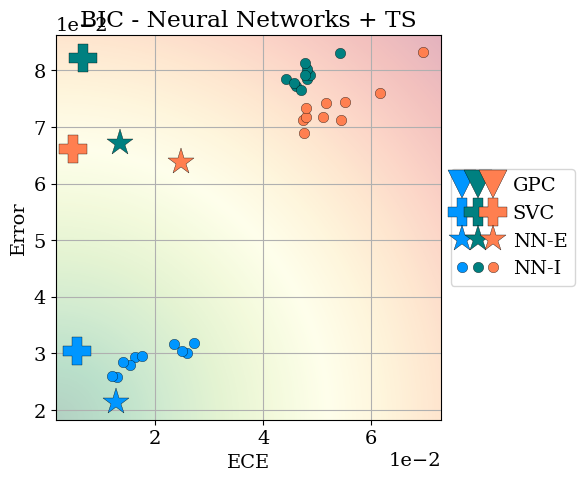

In [11]:
plt.figure(figsize=(5,5))
ax = plt.axes()
ax.set_title('BIC - Neural Networks + TS')
ax.set_xlabel('ECE')
ax.set_ylabel('Error')
ax.ticklabel_format(style='sci', scilimits=(-1,-3))
ax.grid('on')

colors = ['#0096FF', '#008080', '#FF7F50']

"""
c0_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_gpc, ERRs_gpc)):
        c0_plots.append(plt.plot(eces, errs, 'v', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))
"""
c1_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_svc, ERRs_svc)):
        c1_plots.append(plt.plot(eces, errs, 'P', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c2_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn_agg, ERRs_nn_agg)):
        c2_plots.append(plt.plot(eces, errs, '*', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c3_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn, ERRs_nn)):
    c3_plots.append(plt.plot(eces[0], errs[0], '.', color=colors[d_num], markersize=15, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0)[0])
    plt.plot(eces[1:], errs[1:], '.', color=colors[d_num], markersize=15, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0)

xx = list(ax.get_xlim())
yy = list(ax.get_ylim())
res = 256
backg = np.zeros((res, res))
for i in range(res):
    for j in range(res):
        backg[res-i-1, j] = -np.sqrt((1+i)**2 + (1+j)**2)
plt.imshow(backg, cmap='RdYlGn', extent=[xx[0], xx[1], yy[0], yy[1]], alpha=0.3)

plt.legend([c0_plots, c1_plots, c2_plots, c3_plots], ['GPC', 'SVC', 'NN-E', 'NN-I'], handler_map={list: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_aspect((xx[1]-xx[0]) / (yy[1]-yy[0]))

#plt.savefig('figures/figure3-errVSece.svg', transparent=True)
plt.savefig('figures/figure3-errVSece.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

# Figure 4

In [28]:
tr_sizes = [200, 500, 1000, 2000, 5000, 10000]
datasets = [1, 2, 3]

ECEs_gpc = []
ERRs_gpc = []
MCEs_gpc = []
ECEs_svc = []
ERRs_svc = []
MCEs_svc = []
ECEs_nn = []
ERRs_nn = []
MCEs_nn = []
ECEs_nn_agg = []
ERRs_nn_agg = []
MCEs_nn_agg = []
for d_num in datasets:
    test_output = np.loadtxt(f'data/BIC{d_num}/test_output_data.txt')
    
    eces_gpc = []
    errs_gpc = []
    mces_gpc = []
    eces_svc = []
    errs_svc = []
    mces_svc = []
    eces_nn = []
    errs_nn = []
    mces_nn = []
    eces_nn_agg = []
    errs_nn_agg = []
    mces_nn_agg = []    
    for tr_size in tr_sizes:
        probs = np.load(f'results/BIC{d_num}/GPC/probs-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_gpc.append(ece)
        errs_gpc.append(1 - acc)
        mces_gpc.append(mce)

        probs = np.load(f'results/BIC{d_num}/SVC/probs-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_svc.append(ece)
        errs_svc.append(1 - acc)
        mces_svc.append(mce)

        eces = []
        errs = []
        mces = []
        for model_num in range(10):
            probs = np.load(f'results/BIC{d_num}/NN/probs-test-tr_size-{tr_size}-model_num-{model_num}.npy')
            _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
            eces.append(ece)
            errs.append(1 - acc)
            mces.append(mce)
        eces_nn.append(eces)
        errs_nn.append(errs)
        mces_nn.append(mces)

        probs = np.load(f'results/BIC{d_num}/NN-AGG/probs-test-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_nn_agg.append(ece)
        errs_nn_agg.append(1 - acc)
        mces_nn_agg.append(mce)
    
    ECEs_gpc.append(eces_gpc)
    ERRs_gpc.append(errs_gpc)
    MCEs_gpc.append(mces_gpc)

    ECEs_svc.append(eces_svc)
    ERRs_svc.append(errs_svc)
    MCEs_svc.append(mces_svc)

    ECEs_nn.append(eces_nn)
    ERRs_nn.append(errs_nn)
    MCEs_nn.append(mces_nn)

    ECEs_nn_agg.append(eces_nn_agg)
    ERRs_nn_agg.append(errs_nn_agg)
    MCEs_nn_agg.append(mces_nn_agg)

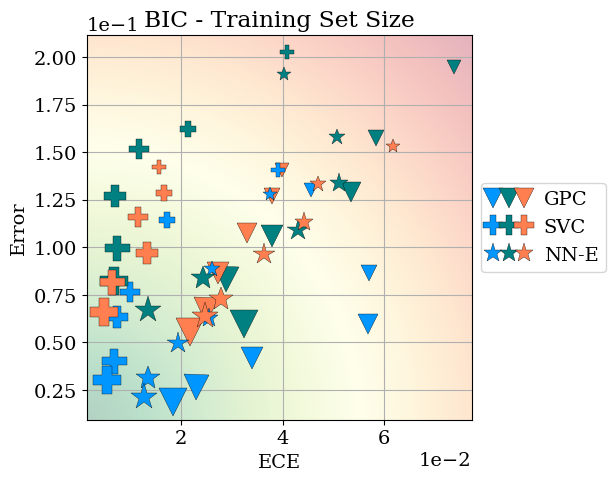

In [30]:
plt.figure(figsize=(5,5))
ax = plt.axes()
ax.set_title('BIC - Training Set Size')
ax.set_xlabel('ECE')
ax.set_ylabel('Error')
ax.ticklabel_format(style='sci', scilimits=(-1,-3))
ax.grid('on')

colors = ['#0096FF', '#008080', '#FF7F50']

c0_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_gpc, ERRs_gpc)):
    for tr_size, (ece, err) in enumerate(zip(eces, errs)):
        if tr_size == 2:
            c0_plots.append(plt.plot(ece, err, 'v', color=colors[d_num], markersize=2*tr_size+10, markeredgecolor='k', markeredgewidth=0.25)[0])
        else:
            plt.plot(ece, err, 'v', color=colors[d_num], markersize=2*tr_size+10, markeredgecolor='k', markeredgewidth=0.25)

c1_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_svc, ERRs_svc)):
    for tr_size, (ece, err) in enumerate(zip(eces, errs)):
        if tr_size == 2:
            c1_plots.append(plt.plot(ece, err, 'P', color=colors[d_num], markersize=2*tr_size+10, markeredgecolor='k', markeredgewidth=0.25)[0])
        else:
            plt.plot(ece, err, 'P', color=colors[d_num], markersize=2*tr_size+10, markeredgecolor='k', markeredgewidth=0.25)

c2_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn_agg, ERRs_nn_agg)):
    for tr_size, (ece, err) in enumerate(zip(eces, errs)):
        if tr_size == 2:
            c2_plots.append(plt.plot(ece, err, '*', color=colors[d_num], markersize=2*tr_size+10, markeredgecolor='k', markeredgewidth=0.25)[0])
        else:
            plt.plot(ece, err, '*', color=colors[d_num], markersize=2*tr_size+10, markeredgecolor='k', markeredgewidth=0.25)

xx = list(ax.get_xlim())
yy = list(ax.get_ylim())

res = 256
backg = np.zeros((res, res))
for i in range(res):
    for j in range(res):
        backg[res-i-1, j] = -np.sqrt((1+i)**2 + (1+j)**2)
plt.imshow(backg, cmap='RdYlGn', extent=[xx[0], xx[1], yy[0], yy[1]], alpha=0.3)

plt.legend([c0_plots, c1_plots, c2_plots], ['GPC', 'SVC', 'NN-E'], handler_map={list: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_aspect((xx[1]-xx[0]) / (yy[1]-yy[0]))

#plt.savefig('figures/figure5-errVSece-tr-size.svg', transparent=True)
plt.savefig('figures/figure5-errVSece-tr-size.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

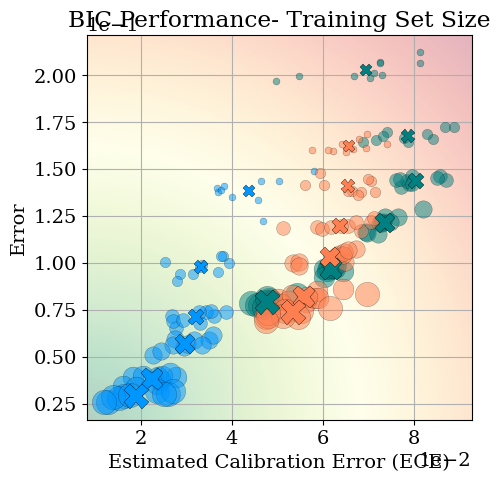

In [19]:
plt.figure(figsize=(5,5))
ax = plt.axes()
ax.set_title('BIC Performance- Training Set Size')
ax.set_xlabel('Estimated Calibration Error (ECE)')
ax.set_ylabel('Error')
ax.ticklabel_format(style='sci', scilimits=(-1,-3))
ax.grid('on')

colors = ['#0096FF', '#008080', '#FF7F50']

c2_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn, ERRs_nn)):
    for tr_size, (ece, err) in enumerate(zip(eces, errs)):
        #if tr_size % 2 == 0:
        if tr_size == 2:
            c2_plots.append(plt.plot(ece, err, '.', color=colors[d_num], markersize=5*(tr_size+2), markeredgecolor='k', markeredgewidth=0.25, alpha=0.5)[0])
        else:
            plt.plot(ece, err, '.', color=colors[d_num], markersize=5*(tr_size+2), markeredgecolor='k', markeredgewidth=.25, alpha=0.5)
        
for d_num, (eces, errs) in enumerate(zip(ECEs_nn, ERRs_nn)):
    for tr_size, (ece, err) in enumerate(zip(eces, errs)):
        plt.plot(np.mean(ece), np.mean(err), 'X', color=colors[d_num], markersize=2*(tr_size+4), markeredgecolor='k', markeredgewidth=0.25)
        
xx = list(ax.get_xlim())
yy = list(ax.get_ylim())

res = 256
backg = np.zeros((res, res))
for i in range(res):
    for j in range(res):
        backg[res-i-1, j] = -np.sqrt((1+i)**2 + (1+j)**2)
plt.imshow(backg, cmap='RdYlGn', extent=[xx[0], xx[1], yy[0], yy[1]], alpha=0.3)

ax.set_aspect((xx[1]-xx[0]) / (yy[1]-yy[0]))

#plt.savefig('figures/figure6-errVSece-tr-size.svg', transparent=True)
plt.savefig('figures/figure6-errVSece-tr-size.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

# Figure 5

### BIC

In [34]:
tr_sizes = [10000]
datasets = [1, 2, 3]

ECEs_nn = []
ERRs_nn = []
MCEs_nn = []
ECEs_nn_ts = []
ERRs_nn_ts = []
MCEs_nn_ts = []
ECEs_nn_agg = []
ERRs_nn_agg = []
MCEs_nn_agg = []
ECEs_nn_agg_ts = []
ERRs_nn_agg_ts = []
MCEs_nn_agg_ts = []
ECEs_nn_ts_agg = []
ERRs_nn_ts_agg = []
MCEs_nn_ts_agg = []
for d_num in datasets:
    test_output = np.loadtxt(f'data/BIC{d_num}/test_output_data.txt')
    
    eces_nn = []
    errs_nn = []
    mces_nn = []
    eces_nn_ts = []
    errs_nn_ts = []
    mces_nn_ts = []
    eces_nn_agg = []
    errs_nn_agg = []
    mces_nn_agg = []
    eces_nn_agg_ts = []
    errs_nn_agg_ts = []
    mces_nn_agg_ts = []
    eces_nn_ts_agg = []
    errs_nn_ts_agg = []
    mces_nn_ts_agg = []  
    for tr_size in tr_sizes:
        eces = []
        errs = []
        mces = []
        for model_num in range(10):
            probs = np.load(f'results/BIC{d_num}/NN/probs-test-tr_size-{tr_size}-model_num-{model_num}.npy')
            _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
            eces.append(ece)
            errs.append(1 - acc)
            mces.append(mce)
        eces_nn.append(eces)
        errs_nn.append(errs)
        mces_nn.append(mces)

        eces = []
        errs = []
        mces = []
        for model_num in range(10):
            probs = np.load(f'results/BIC{d_num}/NN-TS/probs-test-tr_size-{tr_size}-model_num-{model_num}.npy')
            _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
            eces.append(ece)
            errs.append(1 - acc)
            mces.append(mce)
        eces_nn_ts.append(eces)
        errs_nn_ts.append(errs)
        mces_nn_ts.append(mces)

        probs = np.load(f'results/BIC{d_num}/NN-AGG/probs-test-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_nn_agg.append(ece)
        errs_nn_agg.append(1 - acc)
        mces_nn_agg.append(mce)

        probs = np.load(f'results/BIC{d_num}/NN-AGG-TS/probs-test-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_nn_agg_ts.append(ece)
        errs_nn_agg_ts.append(1 - acc)
        mces_nn_agg_ts.append(mce)

        probs = np.load(f'results/BIC{d_num}/NN-TS-AGG/probs-test-tr_size-{tr_size}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces_nn_ts_agg.append(ece)
        errs_nn_ts_agg.append(1 - acc)
        mces_nn_ts_agg.append(mce)
    
    ECEs_nn.append(eces_nn)
    ERRs_nn.append(errs_nn)
    MCEs_nn.append(mces_nn)

    ECEs_nn_ts.append(eces_nn_ts)
    ERRs_nn_ts.append(errs_nn_ts)
    MCEs_nn_ts.append(mces_nn_ts)

    ECEs_nn_agg.append(eces_nn_agg)
    ERRs_nn_agg.append(errs_nn_agg)
    MCEs_nn_agg.append(mces_nn_agg)

    ECEs_nn_agg_ts.append(eces_nn_agg_ts)
    ERRs_nn_agg_ts.append(errs_nn_agg_ts)
    MCEs_nn_agg_ts.append(mces_nn_agg_ts)

    ECEs_nn_ts_agg.append(eces_nn_ts_agg)
    ERRs_nn_ts_agg.append(errs_nn_ts_agg)
    MCEs_nn_ts_agg.append(mces_nn_ts_agg)

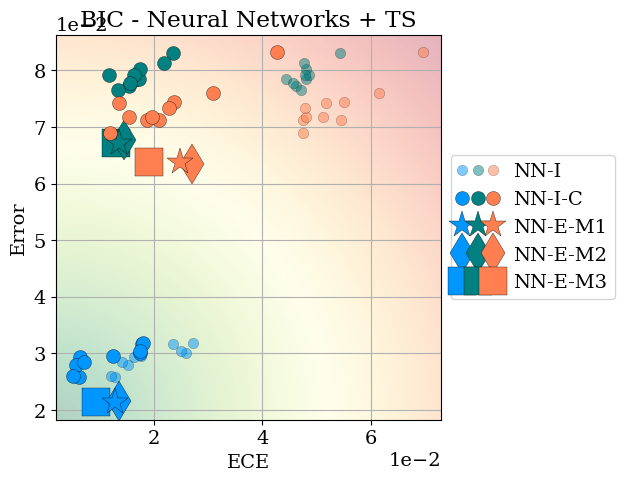

In [35]:
plt.figure(figsize=(5,5))
ax = plt.axes()
ax.set_title('BIC - Neural Networks + TS')
ax.set_xlabel('ECE')
ax.set_ylabel('Error')
ax.ticklabel_format(style='sci', scilimits=(-1,-3))
ax.grid('on')

#colors = ['#4658F5', '#0BDEDA', '#FF7B61']
colors = colors = ['#0096FF', '#008080', '#FF7F50']

c4_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn_agg_ts, ERRs_nn_agg_ts)):
        c4_plots.append(plt.plot(eces, errs, 's', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c3_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn_ts_agg, ERRs_nn_ts_agg)):
        c3_plots.append(plt.plot(eces, errs, 'd', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c2_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn_agg, ERRs_nn_agg)):
        c2_plots.append(plt.plot(eces, errs, '*', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c0_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn, ERRs_nn)):
    c0_plots.append(plt.plot(eces[0], errs[0], '.', color=colors[d_num], markersize=15, markeredgecolor='k', markeredgewidth=0.25, alpha=0.5)[0])
    plt.plot(eces[1:], errs[1:], '.', color=colors[d_num], markersize=15, markeredgecolor='k', markeredgewidth=0.25, alpha=0.5)

c1_plots = []
for d_num, (eces, errs) in enumerate(zip(ECEs_nn_ts, ERRs_nn_ts)):
    c1_plots.append(plt.plot(eces[0], errs[0], '.', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0)[0])
    plt.plot(eces[1:], errs[1:], '.', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0)

xx = list(ax.get_xlim())
yy = list(ax.get_ylim())

res = 256
backg = np.zeros((res, res))
for i in range(res):
    for j in range(res):
        backg[res-i-1, j] = -np.sqrt((1+i)**2 + (1+j)**2)
plt.imshow(backg, cmap='RdYlGn', extent=[xx[0], xx[1], yy[0], yy[1]], alpha=0.3)

plt.legend([c0_plots, c1_plots, c2_plots, c3_plots, c4_plots], ['NN-I', 'NN-I-C', 'NN-E-M1', 'NN-E-M2', 'NN-E-M3'], handler_map={list: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_aspect((xx[1]-xx[0]) / (yy[1]-yy[0]))

#plt.savefig('figures/figure1-errVSece.svg', transparent=True)
plt.savefig('figures/figure1-errVSece.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

### ABC

In [21]:
datasets = [1, 2, 3]

eces_nn = []
errs_nn = []
mces_nn = []
eces_nn_ts = []
errs_nn_ts = []
mces_nn_ts = []
eces_nn_agg = []
errs_nn_agg = []
mces_nn_agg = []
eces_nn_agg_ts = []
errs_nn_agg_ts = []
mces_nn_agg_ts = []
eces_nn_ts_agg = []
errs_nn_ts_agg = []
mces_nn_ts_agg = []  
for d_num in datasets:
    test_output = np.load(f'data/ABC{d_num}/labels_test.npy')

    eces = []
    errs = []
    mces = []
    for model_num in range(10):
        probs = np.load(f'results/ABC{d_num}/NN/probs-test-model_num-{model_num}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces.append(ece)
        errs.append(1 - acc)
        mces.append(mce)
    eces_nn.append(eces)
    errs_nn.append(errs)
    mces_nn.append(mces)

    eces = []
    errs = []
    mces = []
    for model_num in range(10):
        probs = np.load(f'results/ABC{d_num}/NN-TS/probs-test-model_num-{model_num}.npy')
        _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
        eces.append(ece)
        errs.append(1 - acc)
        mces.append(mce)
    eces_nn_ts.append(eces)
    errs_nn_ts.append(errs)
    mces_nn_ts.append(mces)

    probs = np.load(f'results/ABC{d_num}/NN-AGG/probs-test.npy')
    _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
    eces_nn_agg.append(ece)
    errs_nn_agg.append(1 - acc)
    mces_nn_agg.append(mce)

    probs = np.load(f'results/ABC{d_num}/NN-AGG-TS/probs-test.npy')
    _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
    eces_nn_agg_ts.append(ece)
    errs_nn_agg_ts.append(1 - acc)
    mces_nn_agg_ts.append(mce)

    probs = np.load(f'results/ABC{d_num}/NN-TS-AGG/probs-test.npy')
    _, _, ece, acc, mce, _ = calib_curve(probs[:, 1], test_output)
    eces_nn_ts_agg.append(ece)
    errs_nn_ts_agg.append(1 - acc)
    mces_nn_ts_agg.append(mce)

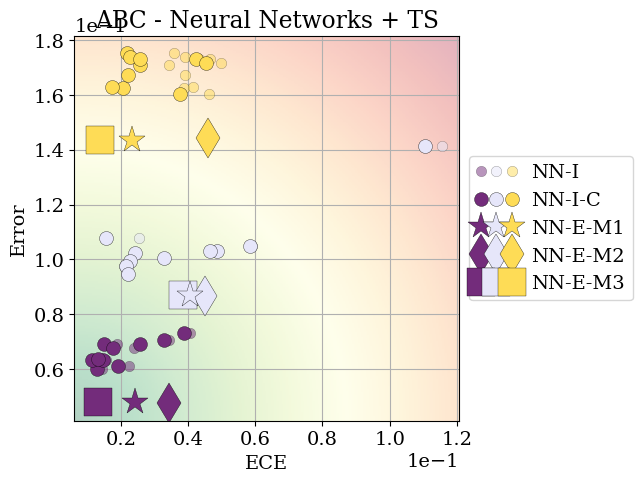

In [22]:
plt.figure(figsize=(5,5))
ax = plt.axes()
ax.set_title('ABC - Neural Networks + TS')
ax.set_xlabel('ECE')
ax.set_ylabel('Error')
ax.ticklabel_format(style='sci', scilimits=(-1,-3))
ax.grid('on')

colors = ['#732C7B', '#E6E6FA', '#fedc56']


c4_plots = []
for d_num, (eces, errs) in enumerate(zip(eces_nn_agg_ts, errs_nn_agg_ts)):
        c4_plots.append(plt.plot(eces, errs, 's', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c3_plots = []
for d_num, (eces, errs) in enumerate(zip(eces_nn_ts_agg, errs_nn_ts_agg)):
        c3_plots.append(plt.plot(eces, errs, 'd', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c2_plots = []
for d_num, (eces, errs) in enumerate(zip(eces_nn_agg, errs_nn_agg)):
        c2_plots.append(plt.plot(eces, errs, '*', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c0_plots = []
for d_num, (eces, errs) in enumerate(zip(eces_nn, errs_nn)):
    c0_plots.append(plt.plot(eces[0], errs[0], '.', color=colors[d_num], markersize=15, markeredgecolor='k', markeredgewidth=0.25, alpha=0.5)[0])
    plt.plot(eces[1:], errs[1:], '.', color=colors[d_num], markersize=15, markeredgecolor='k', markeredgewidth=0.25, alpha=0.5)

c1_plots = []
for d_num, (eces, errs) in enumerate(zip(eces_nn_ts, errs_nn_ts)):
    c1_plots.append(plt.plot(eces[0], errs[0], '.', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0)[0])
    plt.plot(eces[1:], errs[1:], '.', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0)
        

xx = list(ax.get_xlim())
yy = list(ax.get_ylim())

res = 256
backg = np.zeros((res, res))
for i in range(res):
    for j in range(res):
        backg[res-i-1, j] = -np.sqrt((1+i)**2 + (1+j)**2)
plt.imshow(backg, cmap='RdYlGn', extent=[xx[0], xx[1], yy[0], yy[1]], alpha=0.3)

plt.legend([c0_plots, c1_plots, c2_plots, c3_plots, c4_plots], ['NN-I', 'NN-I-C', 'NN-E-M1', 'NN-E-M2', 'NN-E-M3'], handler_map={list: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_aspect((xx[1]-xx[0]) / (yy[1]-yy[0]))

#plt.savefig('figures/figure2-errVSece.svg', transparent=True)
plt.savefig('figures/figure2-errVSece.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

### Crack Path

In [ ]:
test_output = np.load(f'data/Crack-Path/dmg-test.npy').reshape(-1)

eces_nn = []
errs_nn = []
mces_nn = []
for model_num in range(10):
    probs = np.load(f'results/Crack-Path/NN/probs-test-model_num-{model_num}.npy')
    _, _, ece, acc, mce, f1, _ = calib_curve_f1(probs[:, 1], test_output)
    eces_nn.append(ece)
    errs_nn.append(1 - f1)
    mces_nn.append(mce)

eces_nn_ts = []
errs_nn_ts = []
mces_nn_ts = []
for model_num in range(10):
    probs = np.load(f'results/Crack-Path/NN-TS/probs-test-model_num-{model_num}.npy')
    _, _, ece, acc, mce, f1, _ = calib_curve_f1(probs[:, 1], test_output)
    eces_nn_ts.append(ece)
    errs_nn_ts.append(1 - f1)
    mces_nn_ts.append(mce)

probs = np.load(f'results/Crack-Path/NN-AGG/probs-test.npy')
_, _, ece, acc, mce, f1, _ = calib_curve_f1(probs[:, 1], test_output)
eces_nn_agg = ece
errs_nn_agg = 1 - f1
mces_nn_agg = mce

probs = np.load(f'results/Crack-Path/NN-AGG-TS/probs-test.npy')
_, _, ece, acc, mce, f1, _ = calib_curve_f1(probs[:, 1], test_output)
eces_nn_agg_ts = ece
errs_nn_agg_ts = 1 - f1
mces_nn_agg_ts = mce

probs = np.load(f'results/Crack-Path/NN-TS-AGG/probs-test.npy')
_, _, ece, acc, mce, f1, _ = calib_curve_f1(probs[:, 1], test_output)
eces_nn_ts_agg = ece
errs_nn_ts_agg = 1 - f1
mces_nn_ts_agg = mce

In [ ]:
plt.figure(figsize=(5,5))
ax = plt.axes()
ax.set_title('CrackPath - UNet + TS')
ax.set_xlabel('ECE')
ax.set_ylabel('1-F1')
ax.ticklabel_format(style='sci', scilimits=(-1,-3))
ax.grid('on')

colors = ['#bb240c']
d_num = 0

c4_plots = []
ece, err = eces_nn_agg_ts, errs_nn_agg_ts
c4_plots.append(plt.plot(ece, err, 's', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c3_plots = []
ece, err = eces_nn_ts_agg, errs_nn_ts_agg
c3_plots.append(plt.plot(ece, err, 'd', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

c2_plots = []
ece, err = eces_nn_agg, errs_nn_agg
c2_plots.append(plt.plot(ece, err, '*', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0))

flag = 0
c0_plots = []
for ece, err in zip(eces_nn, errs_nn):
    if flag:
        plt.plot(ece, err, '.', color=colors[d_num], markersize=15, markeredgecolor='k', markeredgewidth=0.25, alpha=0.5)
    else:
        c0_plots.append(plt.plot(ece, err, '.', color=colors[d_num], markersize=15, markeredgecolor='k', markeredgewidth=0.25, alpha=0.50)[0])
        flag = 1

flag = 0
c1_plots = []
for ece, err in zip(eces_nn_ts, errs_nn_ts):
    if flag:
        plt.plot(ece, err, '.', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0)
    else:
        c1_plots.append(plt.plot(ece, err, '.', color=colors[d_num], markersize=20, markeredgecolor='k', markeredgewidth=0.25, alpha=1.0)[0])
        flag = 1

xx = list(ax.get_xlim())
yy = list(ax.get_ylim())

ax.set_xlim(xx)
ax.set_ylim(yy)
res = 256
backg = np.zeros((res, res))
for i in range(res):
    for j in range(res):
        backg[res-i-1, j] = -np.sqrt((1+i)**2 + (1+j)**2)
plt.imshow(backg, cmap='RdYlGn', extent=[xx[0], xx[1], yy[0], yy[1]], alpha=0.3)

plt.legend([c0_plots, c1_plots, c2_plots, c3_plots, c4_plots], ['NN-I', 'NN-I-C', 'NN-E-M1', 'NN-E-M2', 'NN-E-M3'], handler_map={list: HandlerTuple(ndivide=None)}, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_aspect((xx[1]-xx[0]) / (yy[1]-yy[0]))

#plt.savefig('figures/figure4-errVSece.svg', transparent=True)
plt.savefig('figures/figure4-errVSece.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()